In [12]:
# 这个文件是anal_1的测试文件，计算了所有国家的相关值，后面的相关性要用
# 但是前面的聚类分析并没有用这个结果，但是我们还是保留

import pandas as pd

df = pd.read_csv("vcdb.csv", low_memory=False)
df.head()

,action.environmental.notes,action.environmental.variety.Deterioration,action.environmental.variety.Earthquake,action.environmental.variety.EMI,action.environmental.variety.ESD,action.environmental.variety.Fire,action.environmental.variety.Flood,action.environmental.variety.Hazmat,action.environmental.variety.Humidity,action.environmental.variety.Hurricane,...,pattern.Basic Web Application Attacks,pattern.System Intrusion,pattern.Social Engineering,pattern.Denial of Service,pattern.Everything Else,actor.Multiple,Actor,victim.industry2.31_33,victim.industry2.44_45,victim.industry2.48_49
0,NaN,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,Internal,False,False,False
1,NaN,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,Internal,False,False,False
2,NaN,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,External,False,False,False
3,NaN,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,Partner,False,False,False
4,NaN,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,External,False,False,False


In [13]:
bool_cols = df.select_dtypes(include='bool').columns.tolist()
country_cols = [col for col in bool_cols if '.country.' in col]
non_country_bool_cols = list(set(bool_cols) - set(country_cols))
countries = list(set([col.split('.')[-1] for col in country_cols]))

country_matrix = pd.DataFrame(0, index=countries, columns=non_country_bool_cols)


for country in countries:
    country_mask_cols = [col for col in country_cols if col.endswith(f'.{country}')]
    country_rows = df[df[country_mask_cols].any(axis=1)]
    country_matrix.loc[country] = country_rows[bool_cols].sum()



In [14]:
import pandas as pd

victim_country_cols = [col for col in df.columns if col.startswith('victim.country.')]
victim_countries = [col.split('.')[-1] for col in victim_country_cols]
# 按列求和，得到每个国家被攻击的次数
victim_counts = df[victim_country_cols].sum().values
victim_df = pd.DataFrame({'victim_count': victim_counts}, index=victim_countries)


external_country_cols = [col for col in df.columns if col.startswith('actor.external.country.')]
external_countries = [col.split('.')[-1] for col in external_country_cols]
# 按列求和，得到每个国家作为外部攻击者的次数
external_counts = df[external_country_cols].sum().values
external_df = pd.DataFrame({'external_count': external_counts}, index=external_countries)

all_countries = list(set(victim_countries + external_countries))
result = pd.DataFrame(index=all_countries)
result = result.join(victim_df, how='left').join(external_df, how='left').fillna(0)

result.to_csv("country_attack_counts.csv")
print(result.sort_values('victim_count', ascending=False))

         victim_count  external_count
US               7493             330
GB                592              49
CA                380              22
Unknown           219            4236
AU                174              13
...               ...             ...
GI                  0               0
LA                  0               0
EH                  0               0
DM                  0               0
SN                  0               0

[252 rows x 2 columns]


In [15]:
import pandas as pd

df_v = pd.read_csv("valid_data_v.csv", usecols=["country_code", "attack_density"]).rename(columns={"attack_density": "vd"})
df_a = pd.read_csv("valid_data_a.csv", usecols=["country_code", "attack_density"]).rename(columns={"attack_density": "ad"})

merged_df = pd.merge(df_v, df_a, on="country_code", how="outer")

merged_df.set_index("country_code", inplace=True)
# 这里避免了对国家筛选
#merged_df = merged_df[(merged_df['vd'] > 0) & (merged_df['vd'] < 23) & (merged_df['ad'] > 0) & (merged_df['ad'] < 23)]


# 查看结果
print(merged_df)

                     vd        ad
country_code                     
AD             0.000000  0.000000
AE             1.516622  0.000000
AF             0.049729  0.049729
AG            10.211584  0.000000
AI             0.000000  0.000000
...                 ...       ...
YT             0.000000  0.000000
ZA             0.421523  0.000000
ZM             0.054395  0.000000
ZW             0.269126  0.000000
NaN            0.787118  0.000000

[249 rows x 2 columns]


In [16]:
max_vd = merged_df['vd'].max()

merged_df['X'] = (merged_df['vd'] / max_vd) * 100

if max_vd == 0:
    merged_df['X'] = 0

print("\nX坐标计算结果：")
print(merged_df[['vd', 'X']].sort_values('X', ascending=False).head())


X坐标计算结果：
                        vd           X
country_code                          
UM            26666.666667  100.000000
CK              386.740331    1.450276
MC               25.481602    0.095556
US               22.741612    0.085281
NZ               20.848494    0.078182


In [17]:

merged_df['ad_rank'] = merged_df['ad'].rank(ascending=False, method='min')

N = len(merged_df) - 1

merged_df['Y'] = 100 * (N - merged_df['ad_rank']) / (N - 1)

print("\nY坐标计算结果：")
print(merged_df[['ad', 'ad_rank', 'Y']].sort_values('Y', ascending=False).head())

merged_df.Y.mean()


Y坐标计算结果：
                     ad  ad_rank           Y
country_code                                
TC            25.827780      1.0  100.000000
BZ             7.544873      2.0   99.595142
RU             6.072000      3.0   99.190283
IS             2.729071      4.0   98.785425
SY             2.171347      5.0   98.380567


np.float64(74.02678293366553)

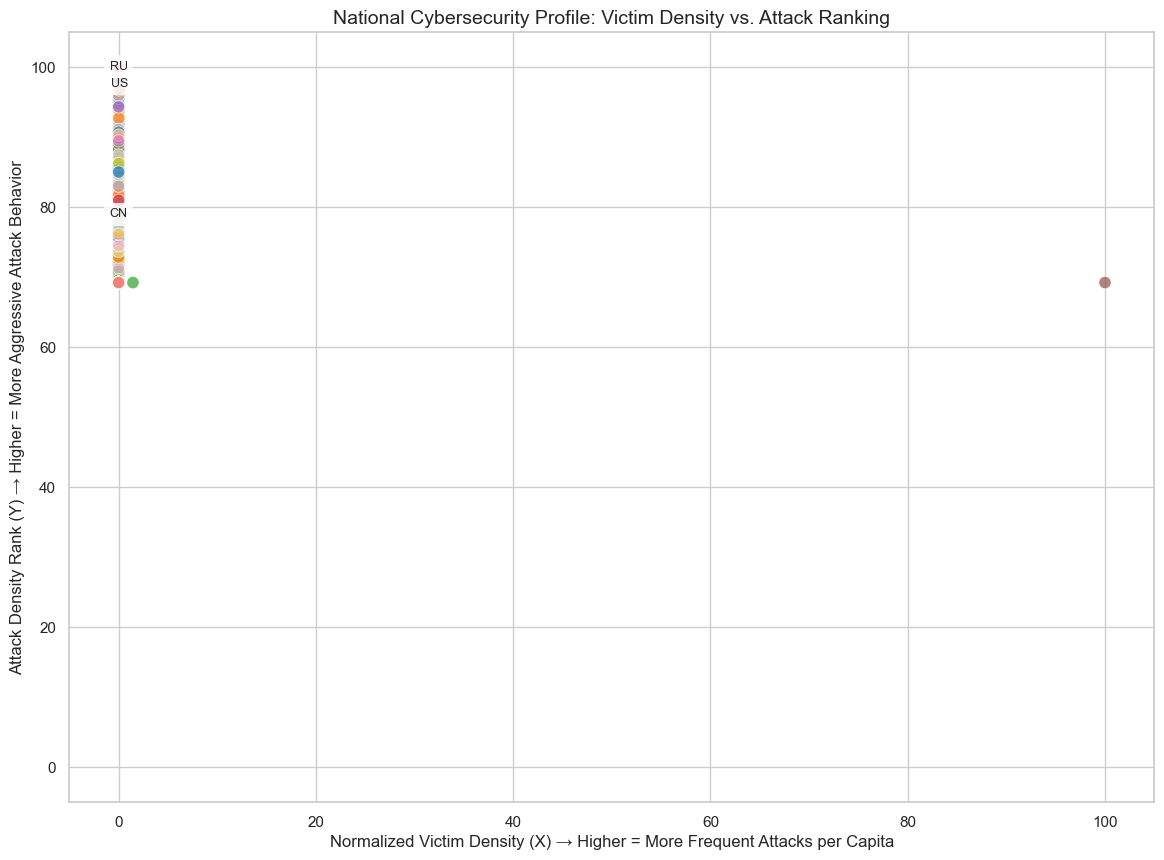

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.set_theme(style="whitegrid")

scatter = sns.scatterplot(
    x='X',
    y='Y',
    data=merged_df,
    hue=merged_df.index,
    palette='tab20',
    s=80,
    alpha=0.7,
    legend=False
)

highlight_countries = ['US', 'RU', 'CN']
for country in highlight_countries:
    if country in merged_df.index:
        x = merged_df.loc[country, 'X']
        y = merged_df.loc[country, 'Y']
        plt.text(x, y, country,
                 fontsize=9,
                 ha='center',
                 va='bottom',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.title("National Cybersecurity Profile: Victim Density vs. Attack Ranking", fontsize=14)
plt.xlabel("Normalized Victim Density (X) → Higher = More Frequent Attacks per Capita", fontsize=12)
plt.ylabel("Attack Density Rank (Y) → Higher = More Aggressive Attack Behavior", fontsize=12)

plt.xlim(-5, 105)
plt.ylim(-5, 105)

if 'UMI' in merged_df.index:
    plt.text(merged_df.loc['UMI', 'X'], merged_df.loc['UMI', 'Y'], 'UMI (Outlier)',
             fontsize=8, color='red', ha='center', va='bottom')

plt.show()

In [19]:
import pandas as pd

df = pd.read_csv('vcdb.csv', low_memory=False)

country_columns = [col for col in df.columns if col.startswith('victim.country.')]
df = df[df[country_columns].any(axis=1)].copy()

# 定义评分函数
def calculate_score(row):
    score = 0

    if row.get('discovery_method.internal.variety.Security alarm', False) == True:
        score += 20

    if row.get('attribute.confidentiality.data_disclosure.No', False) == True:
        score += 20

    if row.get('action.malware.result.NA', False) == True:
        score += 20

    if row.get('action.hacking.variety.Exploit vuln', True) == False:
        score += 20

    if row.get('impact.overall_rating.Insignificant', False) == True:
        score += 20

    return score

df['score'] = df.apply(calculate_score, axis=1)

def get_country(row):
    for col in country_columns:
        if row[col] == True:
            return col.split('.')[-1]
    return None

df['country'] = df.apply(get_country, axis=1)
df = df[df['country'].notna()]

result = df.groupby('country').agg(
    total_attacks=('score', 'count'),
    total_score=('score', 'sum')
).reset_index()

result['Z_value'] = (result['total_score'] / result['total_attacks']).round(2)
result.set_index('country', inplace=True)

print(result.sort_values(by='Z_value', ascending=False))

result.to_csv('defense_success_rate_by_country.csv', index=False)

         total_attacks  total_score  Z_value
country                                     
AG                   1           40    40.00
GU                   1           40    40.00
HN                   3          120    40.00
UY                   1           40    40.00
RW                   1           40    40.00
...                ...          ...      ...
CH                  19          360    18.95
US                7492       141460    18.88
QA                   3           40    13.33
GT                   2           20    10.00
LK                   2            0     0.00

[141 rows x 3 columns]


In [20]:
merged_with_z = merged_df.join(result[['Z_value']], how='left')

merged_with_z['Z_value'] = merged_with_z['Z_value'].fillna(0)


merged_with_z = merged_with_z.rename(columns={'Z_value': 'Z'})

z_min = merged_with_z['Z'].min()
z_max = merged_with_z['Z'].max()

if z_min == z_max:
    merged_with_z['Z_normalized'] = 50.0
else:
    merged_with_z['Z_normalized'] = (merged_with_z['Z'] - z_min) / (z_max - z_min) * 100



merged_with_z = merged_with_z.drop(columns=['Z'])

merged_with_z = merged_with_z.rename(columns={'Z_normalized': 'Z'})


merged_with_z[['X', 'Y', 'Z']]

merged_with_z.to_csv("merged_with_z.csv")

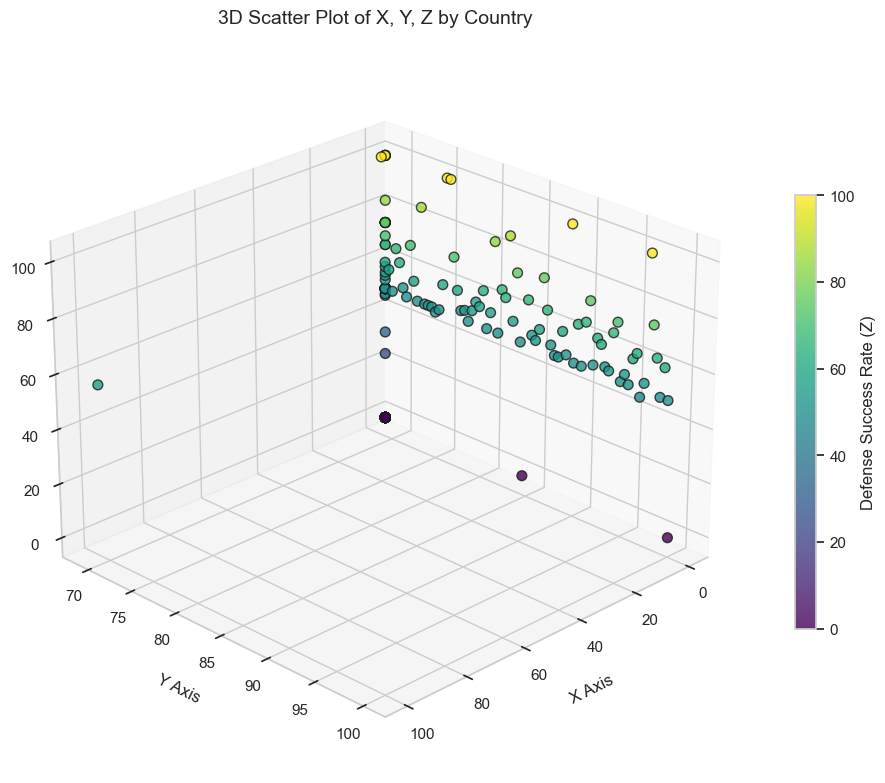

In [21]:
import matplotlib.pyplot as plt



x = merged_with_z['X']
y = merged_with_z['Y']
z = merged_with_z['Z']

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    x, y, z,
    c=z,
    cmap='viridis',
    s=50,
    alpha=0.8,
    edgecolor='k'
)

cbar = fig.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label('Defense Success Rate (Z)', fontsize=12)

ax.set_xlabel('X Axis', fontsize=12, labelpad=10)
ax.set_ylabel('Y Axis', fontsize=12, labelpad=10)
ax.set_zlabel('Z Axis (1-100)', fontsize=12, labelpad=10)

ax.set_title('3D Scatter Plot of X, Y, Z by Country', fontsize=14, pad=20)
ax.view_init(elev=25, azim=45)  #

plt.tight_layout()
plt.show()